In [1]:

import math

def too_naive_softmax(x):
    max_mem = max(x)
    result = [math.e**(xi-max_mem) for xi in x]
    sum_all = sum(result)
    for i in range(len(x)):
        result[i] = result[i]/sum_all
    return result

In [2]:
x = [1000, 999, 998]
too_naive_softmax(x)

[0.6652409557748218, 0.24472847105479764, 0.09003057317038046]

In [3]:
import torch
def naive_softmax(x):
    M, N = x.shape
    # read MN elements, write M elements
    max_mem = torch.max(x, dim=-1).values
    # read MN + M elements, write MN elements
    z = x - max_mem.unsqueeze(-1).expand(M, N)
    # read MN elements, write MN elements
    z = torch.exp(z)
    # read MN elements, write M elements
    row_sum = torch.sum(z,-1).unsqueeze(-1).expand(M, N)
    # read MN + M elements, write MN elements
    result = z/row_sum
    # Total:: Read: 5MN + 2M; Write: 3MN+2M
    return result
    

In [4]:

x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]])
naive_softmax(x)

tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]])

In [5]:
import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()

def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr):
    # tl.device_print("BLOCK_SIZE", BLOCK_SIZE)
    pid = tl.program_id(0)
    row_start_ptr = input_ptr + pid * input_row_stride
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets
    # Load the row data into a block. Use a mask for rows shorter than BLOCK_SIZE.
    mask = col_offsets < n_cols
    row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
    row_max = tl.max(row, axis=0)
    numerator = tl.exp(row - row_max)
    denominator = tl.sum(numerator, axis=0)
    output = numerator / denominator
    
    # Store the result back to global memory.
    output_ptrs = output_ptr + pid * output_row_stride + col_offsets
    tl.store(output_ptrs, output, mask=mask)

In [6]:
def triton_softmax(x: torch.Tensor):
    if not x.is_cuda:
        x = x.cuda()

    n_rows, n_cols = x.shape
    output = torch.empty_like(x)
    grid = (n_rows,)

    softmax_kernel[grid](
        output_ptr=output, 
        input_ptr=x, 
        input_row_stride=x.stride(0),
        output_row_stride=output.stride(0),
        n_rows=n_rows,
        n_cols=n_cols,
        BLOCK_SIZE=triton.next_power_of_2(n_cols)
    )
    
    return output

In [7]:
x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]], device=DEVICE)
triton_softmax(x)

tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]], device='cuda:0')

In [8]:
@triton.jit
def softmax_kernel_better(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

In [59]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def tritorn_softmax_better(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2
    num_stages = 1
    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel_better.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
        # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
        # ISA SECTION (3.6.4 for CDNA3)
        # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
        # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
        # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
        # not required to be equal numbers of both types.
        NUM_GPRS = NUM_REGS
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
        # When we divide this number with WARP_SIZE we get maximum number of waves that can
        # execute on a CU (multi-processor)  in parallel.
        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y

In [60]:
x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]], device=DEVICE)
tritorn_softmax_better(x)

ZeroDivisionError: integer division or modulo by zero

In [86]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        # X-axis configuration: the independent variable we're testing
        x_names=['N'],  # Parameter name that varies across benchmark runs
        x_vals=[128*i for i in range(10, 751, 20)],  # Test sizes from 2^8 (256) to 2^27 (134M) elements
        # x_log=True,  # Use logarithmic scale for x-axis (better for exponential ranges)

        # Line configuration: compare different implementations
        line_arg='provider',  # Parameter that distinguishes different implementations
        # line_vals=['triton', 'torch', 'naive'],  # Internal identifiers for each implementation
        line_vals=['triton', 'torch', 'naive', 'triton_better'],  # Internal identifiers for each implementation
        # line_names=['Triton', 'Torch', 'naive'],  # Display names for the legend
        line_names=['Triton', 'Torch', 'naive', 'triton_better'],  # Display names for the legend
        styles=[('blue', '-'), ('green', '-'), ('red', '-'),  ('black', '-.')],  # (color, line_style) tuples

        # Plot configuration
        ylabel='GB/s',  # Y-axis label (measuring memory bandwidth)
        plot_name='softmax-performance',  # Output filename and plot title
        args={'M': 256},  # Additional fixed arguments (empty here since we only vary size/provider)
    ))
    # basically, the above decorator says that I'm going to have a 2D Diagram
    # x values would be 'size' and lines would be triton, torch and cuda.
def benchmark(M, N, provider):
    """
    Benchmarks vector addition across three implementations: PyTorch, Triton, and CUDA.

    Args:
        size: Number of elements in the vectors
        provider: Which implementation to benchmark ('torch', 'triton', or 'cuda')

    Returns:
        Tuple of (median_gbps, min_gbps, max_gbps) representing bandwidth at different quantiles
    """
    # Create random input tensors on the specified device
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)

    for _ in range(5):
        if provider == 'torch':
            torch.softmax(x, axis=-1)
        elif provider == 'triton':
            triton_softmax(x)
        else:
            naive_softmax(x)
    torch.cuda.synchronize()
    # Quantiles for statistical analysis: [median, 20th percentile, 80th percentile]
    # This captures the distribution of timings across multiple runs
    quantiles = [0.5, 0.2, 0.8]

    # Benchmark each implementation
    # do_bench runs the lambda multiple times and returns timing statistics
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        # Native PyTorch element-wise addition
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        # Custom Triton kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_softmax(x), quantiles=quantiles)
    if provider == 'naive':
        # Custom CUDA kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    if provider == 'triton_better':
        # Custom CUDA kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: tritorn_softmax_better(x), quantiles=quantiles)

    # Calculate memory bandwidth in GB/s
    # Formula breakdown:
    #   - 3 * x.numel(): total elements accessed (read x, read y, write output)
    #   - x.element_size(): bytes per element (4 bytes for float32)
    #   - 1e-9: convert bytes to gigabytes
    #   - (ms * 1e-3): convert milliseconds to seconds
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)

    # Return bandwidth for median, fastest (max_ms → min bandwidth), and slowest (min_ms → max bandwidth)
    # Note: max_ms gives min bandwidth and vice versa
    return gbps(ms), gbps(max_ms), gbps(min_ms)

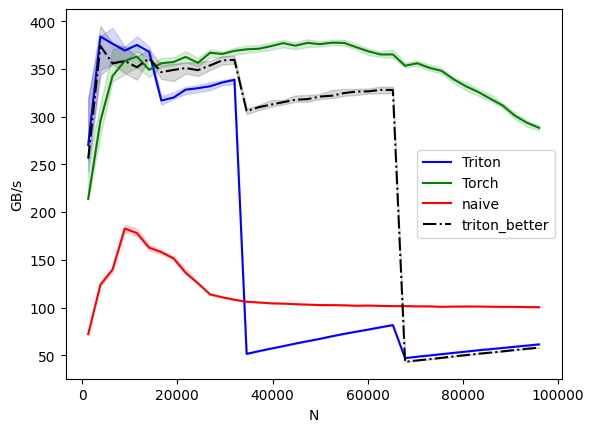

softmax-performance:
          N      Triton       Torch       naive  triton_better
0    1280.0  270.363029  213.890336   72.176210     256.000006
1    3840.0  384.000010  295.384619  123.870969     374.063929
2    6400.0  376.470582  342.761501  139.938507     355.864455
3    8960.0  369.246631  358.400009  182.798858     358.400009
4   11520.0  375.206095  363.013276  178.000971     351.755743
5   14080.0  367.954264  349.135981  162.745168     361.170354
6   16640.0  316.952383  355.995325  158.076299     346.666654
7   19200.0  320.000008  357.313161  151.497965     348.991760
8   21760.0  328.297959  362.666676  136.426327     350.967747
9   24320.0  329.867546  356.418597  125.532703     348.751943
10  26880.0  331.851859  366.962470  113.785301     353.684226
11  29440.0  335.857405  365.714278  110.787318     359.024396
12  32000.0  338.624341  368.975768  108.205207     359.550558
13  34560.0   51.454892  370.616634  106.093628     305.840703
14  37120.0   54.308703  371.20000

In [87]:
benchmark.run(show_plots=True, print_data=True)